# Evaluation Services

## Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from decimal import Decimal
import sys
!pip install pycm==3.1
from pycm import *
import scikitplot as skplt
from collections import OrderedDict
import sklearn    
from sklearn.metrics import confusion_matrix

## Import results Clarabridge test messages

In [2]:
combinedjson = pd.read_json('..\\EvaluationServices\\results\\combined.json')
ibm = pd.read_json('..\\EvaluationServices\\results\\ibm.json')
azure = pd.read_json('..\\EvaluationServices\\results\\azure.json')
clarabridge = pd.read_json('..\\EvaluationServices\\results\\clara.json')
dialogflow = pd.read_json('..\\EvaluationServices\\results\\dialogflow.json')
amazon = pd.read_json('..\\EvaluationServices\\results\\amazon.json')

## Import results Banking test messages

In [3]:
combinedjsonset2 = pd.read_json('..\\EvaluationServices\\resultsdataset2\\combined.json')
ibmset2 = pd.read_json('..\\EvaluationServices\\resultsdataset2\\ibmDataset2.json')
azureset2 = pd.read_json('..\\EvaluationServices\\resultsdataset2\\azureDataset2.json')
dataset2 = pd.read_json('..\\EvaluationServices\\resultsdataset2\\test.json')
dialogflowset2 = pd.read_json('..\\EvaluationServices\\resultsdataset2\\dialogflowDataset2.json')

## General Functions

### Function avg score

In [4]:
def scoreAmounts(target):
    print("avg score:")
    print(target["score"].mean())
    print("\n")

### Function

In [5]:

def GenerateAndCalculate(target, intents):
    # calculate number of count per intent based on intent van de service
    num_total_per_intent = pd.DataFrame(target.groupby('intent').size(), intents).fillna(0)
    
    # calculate number of count per intent based on dataset
    num_total_per_intent_gt = pd.DataFrame(dataset2.groupby('intent').size(), intents).fillna(0)
    
    # Generate confusion matrix
    matrix = confusion_matrix(dataset2["intent"], target["intent"], labels=intents)
    
    # Calculate True Positive (TP)
    TP = np.diag(matrix)
    
    # Calculate False Positive (FP)
    FP = np.sum(matrix, axis=0) - TP
    
    # Calculate False Negative (FN)
    FN = np.sum(matrix, axis=1) - TP
    
    # Calculate True Negative (TN)
    TN = []
    for i in range(len(intents)):
        row_del = np.delete(matrix, i, 0)
        col_del = np.delete(row_del, i, 1) 
        TN.append(sum(sum(col_del)))
        
    # Get total number of utterances
    total_num = np.sum(TP+FP)
    
    # Get total number of correctly classified utterances
    total_correct = np.sum(TP)
    
    # Get total number of incorrectly classified utterances
    total_wrong = np.sum(FP)
    
    # Utterances that were not found, to long or to short for the service
    
    #print TP, FP, Fn
    print('\tTrue Positive: {}'.format(sum(TP)))
    print('\tFalse Positive: {}'.format(sum(FP)))
    print('\tFalse Negative: {}'.format(sum(FN)))
    print('\tNumber of intents: {}'.format(len(intents)))
    print('\tNumber of Utterances used: {}'.format(total_num))
    print('\tTotal correct utterances: {}'.format(total_correct))
    print('\tTotal wrong utterances: {}'.format(total_wrong))
    
    #return dataframe with needed values
    return pd.DataFrame(OrderedDict( ( ('Intents', intents), ('True Positives', TP), ('False Positives', FP), ('True Negatives', TN), ('False Negatives', FN), ('Total Utterances (service)', num_total_per_intent[0]),('Total Utterances (dataset)', num_total_per_intent_gt[0]), ('Total Errors', FP + FN))))

    
    

### Function to calculate precision

In [6]:
def CalculatePrecision(df, intents):
    #Get TP_FP
    TP = df["True Positives"]
    FP = df["False Positives"]
    TP_FP = TP + FP
    
    # Calculate precision by intents
    precision_list = pd.DataFrame({'True Positives': TP,'False Positives': FP, 'True&False Positive': TP_FP, 'Intents': intents})

    # Remove invalid intent
    invalid_intent_precision = precision_list[precision_list['True&False Positive']==0]['Intents']
    precision_list = precision_list[precision_list['True&False Positive']>0]

    # Calculate precision per intent
    precision_list['Precision'] = precision_list['True Positives'].divide(precision_list['True&False Positive']).values
    precision_list = precision_list.join(df[['Total Utterances (service)', 'Total Utterances (dataset)']], on='Intents')
    
    # Sort dataframe by precision and add related columns
    worst_prec = precision_list.sort_values(['Precision', 'False Positives'], ascending=[True, False])[['Intents','Total Utterances (service)', 'Total Utterances (dataset)', 'True Positives', 
                                                           'False Positives', 'Precision']].reset_index(drop=True)
    
    # Calculate averaged precision
    avg_prec = np.average(precision_list['Precision'])
    
    # Print Precision and Variance
    print('\tAverage Precision: {}'.format(avg_prec))

    return worst_prec

### Function to calculate recall

In [7]:
def CalculateRecall(df, intents):
    #Get TP_FP
    TP = df["True Positives"]
    FN = df["False Negatives"]
    TP_FN = TP + FN

    # Calculate recall by intents
    recall_list = pd.DataFrame({'True Positives': TP,'False Negatives': FN, 'Intents': intents, 'True Positive&False Negative': TP_FN})

    # Remove invalid intent
    invalid_intent_recall = recall_list[recall_list['True Positive&False Negative']==0]['Intents']
    recall_list = recall_list[recall_list['True Positive&False Negative']>0]

    # Calculate precision per intent
    recall_list['Recall'] = recall_list['True Positives'].divide(recall_list['True Positive&False Negative']).values
    recall_list = recall_list.join(df[['Total Utterances (service)', 'Total Utterances (dataset)']], on='Intents')

    # Sort dataframe by recall and add related columns
    worst_recall = recall_list.sort_values(['Recall', 'False Negatives'], ascending=[True, False])[['Intents','Total Utterances (service)','Total Utterances (dataset)', 'True Positives', 'False Negatives',
                                                        'Recall']].reset_index(drop=True)
    
    # Calculate averaged precision
    avg_prec = np.average(recall_list['Recall'])
    
    # Print Precision and Variance
    print('\tAverage Recall: {}'.format(avg_prec))
    
    return worst_recall

### Function to get F1-score

In [8]:
def calculateF1Score(prec,recall):
    f1score = 2*((prec["Precision"]*recall["Recall"]) / (prec["Precision"]+recall["Recall"]))
    f1score = f1score.fillna(0)
    return (sum(f1score) / f1score.size)

### Function to get Accuracy

In [9]:
def calculateAccuracy(df):
    TP = df["True Positives"]
    TN = df["True Negatives"]
    FP = df["False Positives"]
    FN = df["False Negatives"]
    TP_TN = TP + TN
    TP_TN_FP_FN = TP+TN+FP+FN
    accuracy = ((TP_TN)/(TP_TN_FP_FN))
    return (sum(accuracy)/accuracy.size)

### Use pandas_ML libary to calculate

In [10]:
def calculateWithLibrary(target):
    cm = ConfusionMatrix(actual_vector=dataset2["intent"].tolist(), predict_vector=target["intent"].tolist()) 
    print(cm)

## Dataset1: Clarabridge

In [11]:
pivotcount = pd.DataFrame();
pivotcount["ibm"] = ibm.pivot_table(index=['intent'], aggfunc='size')
pivotcount["azure"] = azure.pivot_table(index=['intent'], aggfunc='size')
pivotcount["dialogflow"] =dialogflow.pivot_table(index=['intent'], aggfunc='size')
pivotcount["amazon"] = amazon.pivot_table(index=['intent'], aggfunc='size')
df = pd.DataFrame(data=pivotcount)
df

,ibm,azure,dialogflow,amazon
intent,,,,
flight_baggage,11,11.0,8.0,12.0
flight_baggage_lost,18,23.0,31.0,9.0
flight_booking_information_delay,9,79.0,23.0,54.0
flight_canceled,59,29.0,62.0,60.0
flight_checkin,2,NaN,7.0,2.0
flight_corona,2,3.0,3.0,3.0
flight_delays,18,17.0,18.0,12.0
flight_end_conversation,5,6.0,7.0,5.0
flight_experience_review,5,5.0,4.0,3.0


### Correct and Wrong intents



Clarabridge testdata results
         ibm  amazon  azure  dialogflow
compare                                
false     90     107    163          86
true     196     179    123         200


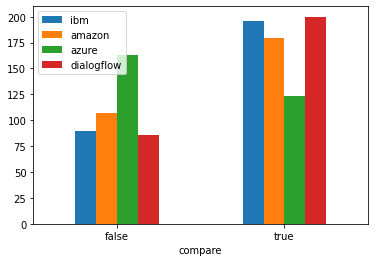

In [12]:
#%%
def test(targetintent):
    test = pd.DataFrame()
    for j in range(0,len(combinedjson)):
        intentclara = combinedjson["services"][j]["clarabridge"]["intent"]
        intent = combinedjson["services"][j][targetintent]["intent"]
        score = combinedjson["services"][j][targetintent]["score"]
        if(isinstance(intentclara, list)):
            #ibm comparison
            query = combinedjson["query"][j]
            if intent in intentclara: b = "true"
            else: b = "false"
            df= pd.Series({'query':query, 'clarabridgeintent':intentclara, targetintent:intent, "score":score, 'compare':b})
            test = pd.concat([test, df.to_frame().T])        
            
    return test

ibmcompare = test("ibm")      
azurecompare = test("azure")
dialogflowcompare = test("dialogflow") 
amazoncompare = test("amazon") 

df1 = ibmcompare.groupby('compare').count()
df2 = amazoncompare.groupby('compare').count()
df12 = pd.merge(df1[{'ibm'}], df2[{'amazon'}], on="compare")

df3 = azurecompare.groupby('compare').count()
df4 = dialogflowcompare.groupby('compare').count()
df34 = pd.merge(df3[{'azure'}], df4[{'dialogflow'}], on="compare")

resultclarabridge = pd.merge(df12,df34, on="compare")
print("\n")
print("Clarabridge testdata results")
print(resultclarabridge)

ax = resultclarabridge.plot.bar(rot=0)

## Dataset2- Banking

In [13]:
intents = pd.unique(dataset2['intent'].values.ravel())
intents = np.append(intents, ["not_found", "to_short", "to_long"])
intents=sorted(intents[~pd.isnull(intents)])

### Dialogflow

In [14]:
dialogflow = GenerateAndCalculate(dialogflowset2, intents)
dialogflow_worst_prec = CalculatePrecision(dialogflow, intents)
dialogflow_worst_recall = CalculateRecall(dialogflow, intents)
dialogflowf1 = calculateF1Score(dialogflow_worst_prec, dialogflow_worst_recall)
dialogflowac = calculateAccuracy(dialogflow)
display(dialogflow_worst_prec.head(10))
display(dialogflow_worst_recall.head(10))

	True Positive: 2783
	False Positive: 297
	False Negative: 297
	Number of intents: 80
	Number of Utterances used: 3080
	Total correct utterances: 2783
	Total wrong utterances: 297
	Average Precision: 0.8872011522813645
	Average Recall: 0.9035714285714285


,Intents,Total Utterances (service),Total Utterances (dataset),True Positives,False Positives,Precision
0,to_long,8.0,0.0,0,8,0.000000
1,not_found,1.0,0.0,0,1,0.000000
2,failed_transfer,51.0,40.0,35,16,0.686275
3,card_not_working,52.0,40.0,38,14,0.730769
4,transfer_into_account,46.0,40.0,36,10,0.782609
5,declined_card_payment,47.0,40.0,37,10,0.787234
6,pending_transfer,39.0,40.0,31,8,0.794872
7,order_physical_card,45.0,40.0,36,9,0.800000
8,topping_up_by_card,40.0,40.0,32,8,0.800000
9,declined_cash_withdrawal,47.0,40.0,38,9,0.808511


,Intents,Total Utterances (service),Total Utterances (dataset),True Positives,False Negatives,Recall
0,virtual_card_not_working,30.0,40.0,29,11,0.725
1,pending_transfer,39.0,40.0,31,9,0.775
2,transfer_not_received_by_recipient,34.0,40.0,31,9,0.775
3,balance_not_updated_after_bank_transfer,39.0,40.0,32,8,0.800
4,disposable_card_limits,35.0,40.0,32,8,0.800
5,top_up_failed,37.0,40.0,32,8,0.800
6,topping_up_by_card,40.0,40.0,32,8,0.800
7,verify_my_identity,37.0,40.0,32,8,0.800
8,beneficiary_not_allowed,33.0,40.0,33,7,0.825
9,card_arrival,38.0,40.0,33,7,0.825


### IBM 

In [15]:
ibm = GenerateAndCalculate(ibmset2, intents)
ibm_worst_prec = CalculatePrecision(ibm, intents)
ibm_worst_recall = CalculateRecall(ibm, intents)
ibmf1 = calculateF1Score(ibm_worst_prec, ibm_worst_recall)
ibmac = calculateAccuracy(ibm)
display(ibm_worst_prec.head(10))
display(ibm_worst_recall.head(10))

	True Positive: 2820
	False Positive: 260
	False Negative: 260
	Number of intents: 80
	Number of Utterances used: 3080
	Total correct utterances: 2820
	Total wrong utterances: 260
	Average Precision: 0.9191941324249183
	Average Recall: 0.9155844155844154


,Intents,Total Utterances (service),Total Utterances (dataset),True Positives,False Positives,Precision
0,not_found,46.0,0.0,0,46,0.000000
1,top_up_failed,42.0,40.0,31,11,0.738095
2,failed_transfer,45.0,40.0,36,9,0.800000
3,balance_not_updated_after_bank_transfer,39.0,40.0,32,7,0.820513
4,pending_transfer,39.0,40.0,32,7,0.820513
5,card_not_working,46.0,40.0,38,8,0.826087
6,declined_card_payment,46.0,40.0,38,8,0.826087
7,topping_up_by_card,41.0,40.0,34,7,0.829268
8,declined_cash_withdrawal,43.0,40.0,36,7,0.837209
9,transfer_into_account,39.0,40.0,34,5,0.871795


,Intents,Total Utterances (service),Total Utterances (dataset),True Positives,False Negatives,Recall
0,declined_transfer,31.0,40.0,31,9,0.775
1,top_up_failed,42.0,40.0,31,9,0.775
2,balance_not_updated_after_bank_transfer,39.0,40.0,32,8,0.800
3,fiat_currency_support,36.0,40.0,32,8,0.800
4,pending_transfer,39.0,40.0,32,8,0.800
5,pin_blocked,35.0,40.0,33,7,0.825
6,transfer_not_received_by_recipient,37.0,40.0,33,7,0.825
7,card_delivery_estimate,37.0,40.0,34,6,0.850
8,disposable_card_limits,36.0,40.0,34,6,0.850
9,top_up_reverted,38.0,40.0,34,6,0.850


### Microsoft

In [16]:
azure = GenerateAndCalculate(azureset2, intents)
azure_worst_prec = CalculatePrecision(azure, intents)
azure_worst_recall = CalculateRecall(azure, intents)
azuref1 = calculateF1Score(azure_worst_prec, azure_worst_recall)
azureac = calculateAccuracy(azure)
display(azure_worst_prec.head(10))
display(azure_worst_recall.head(10))

	True Positive: 2697
	False Positive: 383
	False Negative: 383
	Number of intents: 80
	Number of Utterances used: 3080
	Total correct utterances: 2697
	Total wrong utterances: 383
	Average Precision: 0.8744787383521102
	Average Recall: 0.8756493506493506


,Intents,Total Utterances (service),Total Utterances (dataset),True Positives,False Positives,Precision
0,not_found,14.0,0.0,0,14,0.000000
1,verify_my_identity,44.0,40.0,30,14,0.681818
2,balance_not_updated_after_bank_transfer,45.0,40.0,31,14,0.688889
3,top_up_failed,52.0,40.0,36,16,0.692308
4,transfer_not_received_by_recipient,45.0,40.0,32,13,0.711111
5,card_not_working,50.0,40.0,36,14,0.720000
6,why_verify_identity,35.0,40.0,26,9,0.742857
7,exchange_via_app,49.0,40.0,37,12,0.755102
8,failed_transfer,49.0,40.0,37,12,0.755102
9,cash_withdrawal_not_recognised,46.0,40.0,35,11,0.760870


,Intents,Total Utterances (service),Total Utterances (dataset),True Positives,False Negatives,Recall
0,why_verify_identity,35.0,40.0,26,14,0.650
1,pending_transfer,32.0,40.0,27,13,0.675
2,topping_up_by_card,34.0,40.0,28,12,0.700
3,fiat_currency_support,32.0,40.0,29,11,0.725
4,pending_cash_withdrawal,33.0,40.0,29,11,0.725
5,get_disposable_virtual_card,34.0,40.0,30,10,0.750
6,verify_my_identity,44.0,40.0,30,10,0.750
7,virtual_card_not_working,32.0,40.0,30,10,0.750
8,balance_not_updated_after_bank_transfer,45.0,40.0,31,9,0.775
9,card_payment_not_recognised,38.0,40.0,31,9,0.775


### Summary


In [17]:
print("Dialogflow")
prec = CalculatePrecision(dialogflow, intents)
dialogflowprec = np.average(prec['Precision'])

print("IBM")
prec = CalculatePrecision(ibm, intents)
ibmprec = np.average(prec['Precision'])


print("Microsoft")
prec = CalculatePrecision(azure, intents)
azureprec = np.average(prec['Precision'])
print("")




Dialogflow
	Average Precision: 0.8872011522813645
IBM
	Average Precision: 0.9191941324249183
Microsoft
	Average Precision: 0.8744787383521102



In [18]:
print("Dialogflow")
rec = CalculateRecall(dialogflow, intents)
dialogflowrec = np.average(rec['Recall'])

print("IBM")
rec = CalculateRecall(ibm, intents)
ibmrec = np.average(rec['Recall'])

print("Microsoft")
rec = CalculateRecall(azure, intents)
azurerec = np.average(rec['Recall'])



Dialogflow
	Average Recall: 0.9035714285714285
IBM
	Average Recall: 0.9155844155844154
Microsoft
	Average Recall: 0.8756493506493506


In [19]:
print("Dialogflow")
print("\tAverage F1-score: {}".format(dialogflowf1))

print("IBM")
print("\tAverage F1-score: {}".format(ibmf1))

print("Microsoft")
print("\tAverage F1-score: {}".format(azuref1))

Dialogflow
	Average F1-score: 0.861712431052926
IBM
	Average F1-score: 0.9000504520115854
Microsoft
	Average F1-score: 0.8587991718189301


<AxesSubplot:xlabel='Service'>

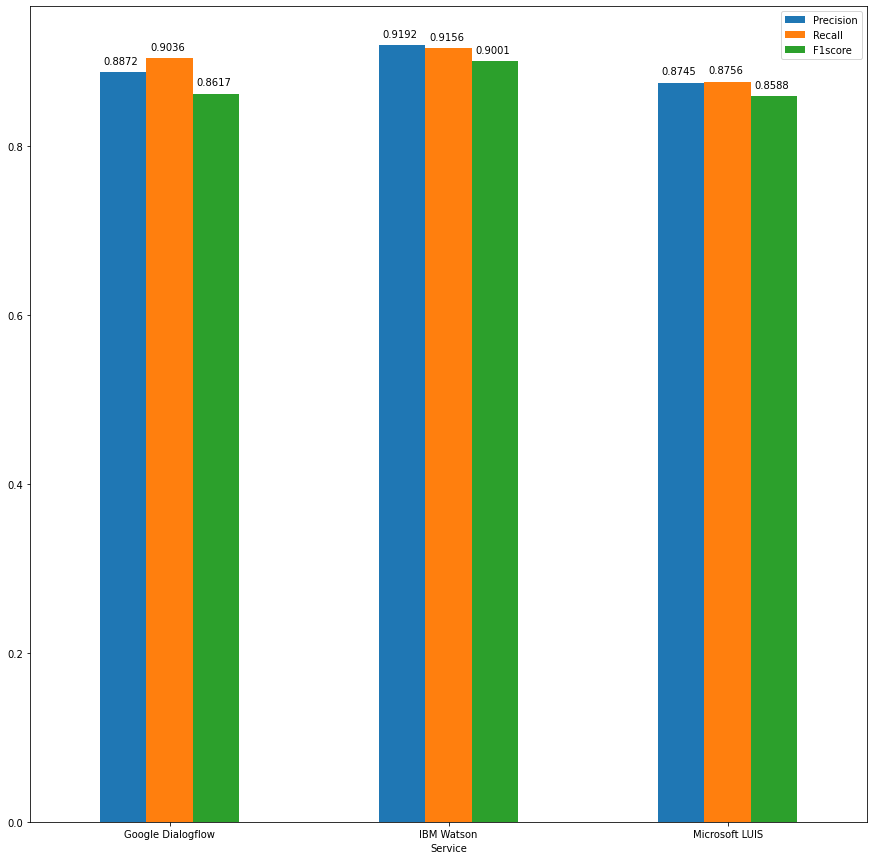

In [20]:
d = {'Service': ['Google Dialogflow','IBM Watson','Microsoft LUIS'], 'Precision': [dialogflowprec, ibmprec, azureprec], 'Recall': [dialogflowrec, ibmrec, azurerec], 'F1score': [dialogflowf1, ibmf1, azuref1]}
df = pd.DataFrame(data=d)
df

x_offset = -0.07
y_offset = 0.01
ax = df.plot.bar(figsize=(15,15), x="Service", rot=0)
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.4f}".format(b.y1 + b.y0)    
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
    
ax

### Dataset2 Accuracy Growth

In [21]:
dialogflowprecision = []

#### 10 examples per intent

In [22]:
combinedjsonset2 = pd.read_json('..\\EvaluationServices\\dataset2_10_examples_results\\combined.json')
ibmset2 = pd.read_json('..\\EvaluationServices\\dataset2_10_examples_results\\ibmDataset2.json')
azureset2 = pd.read_json('..\\EvaluationServices\\dataset2_10_examples_results\\azureDataset2.json')
amazonset2 = pd.read_json('..\\EvaluationServices\\dataset2_10_examples_results\\amazonDataset2.json')
dataset2 = pd.read_json('..\\EvaluationServices\\dataset2_10_examples_results\\test2.json')
dialogflowset2 = pd.read_json('..\\EvaluationServices\\dataset2_10_examples_results\\dialogflowDataset2.json')

In [23]:
print("Dialogflow")
dialogflow = GenerateAndCalculate(dialogflowset2, intents)
dialogflowprec = CalculatePrecision(dialogflow, intents)
dialogflow10 = np.average(dialogflowprec['Precision'])
dialogflowrec = CalculateRecall(dialogflow, intents)
dialogflowrec10 = np.average(dialogflowrec['Recall'])
dialogflowf1_10 = calculateF1Score(dialogflowprec, dialogflowrec)
print("\tF1-score: {}".format(dialogflowf1_10))
dialogflowac10 = calculateAccuracy(dialogflow)
print("\tAccuracy: {}".format(dialogflowac10))

print("IBM")
ibm = GenerateAndCalculate(ibmset2, intents)
ibmprec = CalculatePrecision(ibm, intents)
ibm10 = np.average(ibmprec['Precision'])
ibmrec = CalculateRecall(ibm, intents)
ibmrec10 = np.average(ibmrec['Recall'])
ibmf1_10 = calculateF1Score(ibmprec, ibmrec)
print("\tF1-score: {}".format(ibmf1_10))
ibmac10 = calculateAccuracy(ibm)
print("\tAccuracy: {}".format(ibmac10))

print("Microsoft")
azure = GenerateAndCalculate(azureset2, intents)
azureprec = CalculatePrecision(azure, intents)
azure10 = np.average(azureprec['Precision'])
azurerec = CalculateRecall(azure, intents)
azurerec10 = np.average(azurerec['Recall'])
azuref1_10 = calculateF1Score(azureprec, azurerec)
print("\tF1-score: {}".format(azuref1_10))
azureac10 = calculateAccuracy(azure)
print("\tAccuracy: {}".format(azureac10))
print("")

print("Amazon")
amazon = GenerateAndCalculate(amazonset2, intents)
amazonprec = CalculatePrecision(amazon, intents)
amazon10 = np.average(amazonprec['Precision'])
amazonrec = CalculateRecall(amazon, intents)
amazonrec10 = np.average(amazonrec['Recall'])
amazonf1_10 = calculateF1Score(amazonprec, amazonrec)
print("\tF1-score: {}".format(amazonf1_10))
amazonac10 = calculateAccuracy(amazon)
print("\tAccuracy: {}".format(amazonac10))
print("")

Dialogflow
	True Positive: 381
	False Positive: 149
	False Negative: 149
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 381
	Total wrong utterances: 149
	Average Precision: 0.7205837762799788
	Average Recall: 0.7173778602350032
	F1-score: 0.6928216108156778
	Accuracy: 0.9929716981132076
IBM
	True Positive: 398
	False Positive: 132
	False Negative: 132
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 398
	Total wrong utterances: 132
	Average Precision: 0.795493857993858
	Average Recall: 0.7492269635126776
	F1-score: 0.7578747562415951
	Accuracy: 0.9937735849056601
Microsoft
	True Positive: 329
	False Positive: 201
	False Negative: 201
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 329
	Total wrong utterances: 201
	Average Precision: 0.8385439956868529
	Average Recall: 0.6199752628324057
	F1-score: 0.7068778519311517
	Accuracy: 0.9905188679245288

Amazon
	True Positive: 400
	False Posit

In [24]:
combinedjsonset2 = pd.read_json('..\\EvaluationServices\\dataset2_20_examples_results\\combined.json')
ibmset2 = pd.read_json('..\\EvaluationServices\\dataset2_20_examples_results\\ibmDataset2.json')
azureset2 = pd.read_json('..\\EvaluationServices\\dataset2_20_examples_results\\azureDataset2.json')
amazonset2 = pd.read_json('..\\EvaluationServices\\dataset2_20_examples_results\\amazonDataset2.json')
dataset2 = pd.read_json('..\\EvaluationServices\\dataset2_20_examples_results\\test2.json')
dialogflowset2 = pd.read_json('..\\EvaluationServices\\dataset2_20_examples_results\\dialogflowDataset2.json')

In [25]:
print("Dialogflow")
dialogflow = GenerateAndCalculate(dialogflowset2, intents)
dialogflowprec = CalculatePrecision(dialogflow, intents)
dialogflow20 = np.average(dialogflowprec['Precision'])
dialogflowrec = CalculateRecall(dialogflow, intents)
dialogflowrec20 = np.average(dialogflowrec['Recall'])
dialogflowf1_20 = calculateF1Score(dialogflowprec, dialogflowrec)
print("\tF1-score: {}".format(dialogflowf1_20))
dialogflowac20 = calculateAccuracy(dialogflow)
print("\tAccuracy: {}".format(dialogflowac20))

print("IBM")
ibm = GenerateAndCalculate(ibmset2, intents)
ibmprec = CalculatePrecision(ibm, intents)
ibm20 = np.average(ibmprec['Precision'])
ibmrec = CalculateRecall(ibm, intents)
ibmrec20 = np.average(ibmrec['Recall'])
ibmf1_20 = calculateF1Score(ibmprec, ibmrec)
print("\tF1-score: {}".format(ibmf1_20))
ibmac20 = calculateAccuracy(ibm)
print("\tAccuracy: {}".format(ibmac20))

print("Microsoft")
azure = GenerateAndCalculate(azureset2, intents)
azureprec = CalculatePrecision(azure, intents)
azure20 = np.average(azureprec['Precision'])
azurerec = CalculateRecall(azure, intents)
azurerec20 = np.average(azurerec['Recall'])
azuref1_20 = calculateF1Score(azureprec, azurerec)
print("\tF1-score: {}".format(azuref1_20))
azureac20 = calculateAccuracy(azure)
print("\tAccuracy: {}".format(azureac20))

print("")

print("Amazon")
amazon = GenerateAndCalculate(amazonset2, intents)
amazonprec = CalculatePrecision(amazon, intents)
amazon20 = np.average(amazonprec['Precision'])
amazonrec = CalculateRecall(amazon, intents)
amazonrec20 = np.average(amazonrec['Recall'])
amazonf1_20 = calculateF1Score(amazonprec, amazonrec)
print("\tF1-score: {}".format(amazonf1_20))
amazonac20 = calculateAccuracy(amazon)
print("\tAccuracy: {}".format(amazonac20))
print("")

Dialogflow
	True Positive: 429
	False Positive: 101
	False Negative: 101
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 429
	Total wrong utterances: 101
	Average Precision: 0.8087954591119147
	Average Recall: 0.8085961657390227
	F1-score: 0.7813075637207063
	Accuracy: 0.9952358490566038
IBM
	True Positive: 439
	False Positive: 91
	False Negative: 91
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 439
	Total wrong utterances: 91
	Average Precision: 0.8542022792022792
	Average Recall: 0.8286951144094
	F1-score: 0.8277323083888758
	Accuracy: 0.9957075471698117
Microsoft
	True Positive: 380
	False Positive: 150
	False Negative: 150
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 380
	Total wrong utterances: 150
	Average Precision: 0.8502372627372629
	Average Recall: 0.717068645640074
	F1-score: 0.7624989758296702
	Accuracy: 0.992924528301887

Amazon
	True Positive: 449
	False Positive: 79

In [26]:
combinedjsonset2 = pd.read_json('..\\EvaluationServices\\dataset2_50_examples_results\\combined.json')
ibmset2 = pd.read_json('..\\EvaluationServices\\dataset2_50_examples_results\\ibmDataset2.json')
azureset2 = pd.read_json('..\\EvaluationServices\\dataset2_50_examples_results\\azureDataset2.json')
dataset2 = pd.read_json('..\\EvaluationServices\\dataset2_50_examples_results\\test2.json')
dialogflowset2 = pd.read_json('..\\EvaluationServices\\dataset2_50_examples_results\\dialogflowDataset2.json')

In [27]:
print("Dialogflow")
dialogflow = GenerateAndCalculate(dialogflowset2, intents)
dialogflowprec = CalculatePrecision(dialogflow, intents)
dialogflow50 = np.average(dialogflowprec['Precision'])
dialogflowrec = CalculateRecall(dialogflow, intents)
dialogflowrec50 = np.average(dialogflowrec['Recall'])
dialogflowf1_50 = calculateF1Score(dialogflowprec, dialogflowrec)
print("\tF1-score: {}".format(dialogflowf1_50))
dialogflowac50 = calculateAccuracy(dialogflow)
print("\tAccuracy: {}".format(dialogflowac50))

print("IBM")
ibm = GenerateAndCalculate(ibmset2, intents)
ibmprec = CalculatePrecision(ibm, intents)
ibm50 = np.average(ibmprec['Precision'])
ibmrec = CalculateRecall(ibm, intents)
ibmrec50 = np.average(ibmrec['Recall'])
ibmf1_50 = calculateF1Score(ibmprec, ibmrec)
print("\tF1-score: {}".format(ibmf1_50))
ibmac50 = calculateAccuracy(ibm)
print("\tAccuracy: {}".format(ibmac50))

print("Microsoft")
azure = GenerateAndCalculate(azureset2, intents)
azureprec = CalculatePrecision(azure, intents)
azure50 = np.average(azureprec['Precision'])
azurerec = CalculateRecall(azure, intents)
azurerec50 = np.average(azurerec['Recall'])
azuref1_50 = calculateF1Score(azureprec, azurerec)
print("\tF1-score: {}".format(azuref1_50))
azureac50 = calculateAccuracy(azure)
print("\tAccuracy: {}".format(azureac50))
print("")

Dialogflow
	True Positive: 470
	False Positive: 60
	False Negative: 60
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 470
	Total wrong utterances: 60
	Average Precision: 0.8913031413031413
	Average Recall: 0.8862090290661719
	F1-score: 0.8732791320603426
	Accuracy: 0.997169811320755
IBM
	True Positive: 469
	False Positive: 61
	False Negative: 61
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 469
	Total wrong utterances: 61
	Average Precision: 0.9013888888888889
	Average Recall: 0.8855905998763142
	F1-score: 0.877938451098973
	Accuracy: 0.9971226415094343
Microsoft
	True Positive: 427
	False Positive: 103
	False Negative: 103
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 427
	Total wrong utterances: 103
	Average Precision: 0.8336487586487586
	Average Recall: 0.8051948051948051
	F1-score: 0.805075642799576
	Accuracy: 0.9951415094339623



In [28]:
combinedjsonset2 = pd.read_json('..\\EvaluationServices\\dataset2_80_examples_results\\combined.json')
ibmset2 = pd.read_json('..\\EvaluationServices\\dataset2_80_examples_results\\ibmDataset2.json')
azureset2 = pd.read_json('..\\EvaluationServices\\dataset2_80_examples_results\\azureDataset2.json')
dataset2 = pd.read_json('..\\EvaluationServices\\dataset2_80_examples_results\\test2.json')
dialogflowset2 = pd.read_json('..\\EvaluationServices\\dataset2_80_examples_results\\dialogflowDataset2.json')

In [29]:
print("Dialogflow")
dialogflow = GenerateAndCalculate(dialogflowset2, intents)
dialogflowprec = CalculatePrecision(dialogflow, intents)
dialogflow80 = np.average(dialogflowprec['Precision'])
dialogflowrec = CalculateRecall(dialogflow, intents)
dialogflowrec80 = np.average(dialogflowrec['Recall'])
dialogflowf1_80 = calculateF1Score(dialogflowprec, dialogflowrec)
print("\tF1-score: {}".format(dialogflowf1_80))
dialogflowac80 = calculateAccuracy(dialogflow)
print("\tAccuracy: {}".format(dialogflowac80))

print("IBM")
ibm = GenerateAndCalculate(ibmset2, intents)
CalculatePrecision(ibm, intents)
ibmprec = CalculatePrecision(ibm, intents)
ibm80 = np.average(ibmprec['Precision'])
ibmrec = CalculateRecall(ibm, intents)
ibmrec80 = np.average(ibmrec['Recall'])
ibmf1_80 = calculateF1Score(ibmprec, ibmrec)
print("\tF1-score: {}".format(ibmf1_80))
ibmac80 = calculateAccuracy(ibm)
print("\tAccuracy: {}".format(ibmac80))

print("Microsoft")
azure = GenerateAndCalculate(azureset2, intents)
azureprec = CalculatePrecision(azure, intents)
azure80 = np.average(azureprec['Precision'])
azurerec = CalculateRecall(azure, intents)
azurerec80 = np.average(azurerec['Recall'])
azuref1_80 = calculateF1Score(azureprec, azurerec)
print("\tF1-score: {}".format(azuref1_80))
azureac80 = calculateAccuracy(azure)
print("\tAccuracy: {}".format(azureac80))

print("")

Dialogflow
	True Positive: 475
	False Positive: 55
	False Negative: 55
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 475
	Total wrong utterances: 55
	Average Precision: 0.8950905985716112
	Average Recall: 0.8951762523191095
	F1-score: 0.865305481440224
	Accuracy: 0.9974056603773587
IBM
	True Positive: 476
	False Positive: 54
	False Negative: 54
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 476
	Total wrong utterances: 54
	Average Precision: 0.9140720390720392
	Average Precision: 0.9140720390720392
	Average Recall: 0.898886827458256
	F1-score: 0.8909128816304008
	Accuracy: 0.9974528301886794
Microsoft
	True Positive: 436
	False Positive: 94
	False Negative: 94
	Number of intents: 80
	Number of Utterances used: 530
	Total correct utterances: 436
	Total wrong utterances: 94
	Average Precision: 0.8398125996810207
	Average Recall: 0.8228200371057511
	F1-score: 0.8158453969087652
	Accuracy: 0.9955660377358487



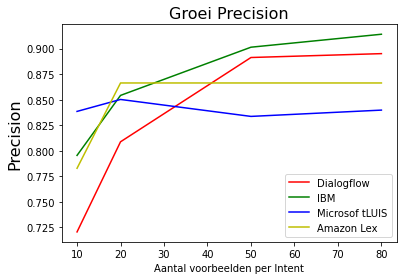

In [30]:
dialogflowgraph = [dialogflow10, dialogflow20, dialogflow50, dialogflow80]
plt.plot([10,20,50,80], dialogflowgraph, color='r')

ibmgraph = [ibm10, ibm20, ibm50, ibm80]
plt.plot([10,20,50,80], ibmgraph, color='g')

azuregraph = [azure10, azure20, azure50, azure80]
plt.plot([10,20,50,80], azuregraph, color='b')

amazongraph = [amazon10, amazon20, amazon20, amazon20]
plt.plot([10,20,50,80], amazongraph, color='y')

plt.legend(['Dialogflow','IBM','Microsof tLUIS','Amazon Lex']) 
plt.xlabel('Aantal voorbeelden per Intent')
plt.ylabel('Precision', fontsize=16) 
plt.title('Groei Precision', fontsize=16)

plt.show()

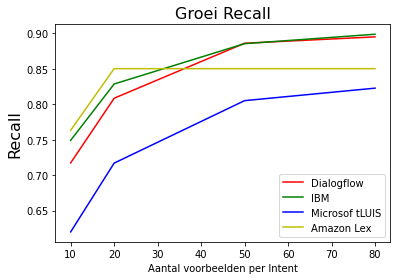

In [31]:
dialogflowgraph = [dialogflowrec10, dialogflowrec20, dialogflowrec50, dialogflowrec80]
plt.plot([10,20,50,80], dialogflowgraph, color='r')

ibmgraph = [ibmrec10, ibmrec20, ibmrec50, ibmrec80]
plt.plot([10,20,50,80], ibmgraph, color='g')

azuregraph = [azurerec10, azurerec20, azurerec50, azurerec80]
plt.plot([10,20,50,80], azuregraph, color='b')

amazongraph = [amazonrec10, amazonrec20, amazonrec20, amazonrec20]
plt.plot([10,20,50,80], amazongraph, color='y')

plt.legend(['Dialogflow','IBM','Microsof tLUIS','Amazon Lex']) 
plt.xlabel('Aantal voorbeelden per Intent')
plt.ylabel('Recall', fontsize=16) 
plt.title('Groei Recall', fontsize=16)

plt.show()

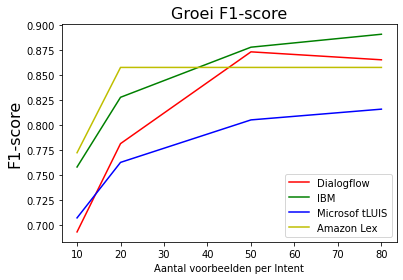

In [32]:
dialogflowgraph = [dialogflowf1_10, dialogflowf1_20, dialogflowf1_50, dialogflowf1_80]
plt.plot([10,20,50,80], dialogflowgraph, color='r')

ibmgraph = [ibmf1_10, ibmf1_20, ibmf1_50, ibmf1_80]
plt.plot([10,20,50,80], ibmgraph, color='g')

azuregraph = [azuref1_10, azuref1_20, azuref1_50, azuref1_80]
plt.plot([10,20,50,80], azuregraph, color='b')

amazongraph = [amazonf1_10, amazonf1_20, amazonf1_20, amazonf1_20]
plt.plot([10,20,50,80], amazongraph, color='y')

plt.legend(['Dialogflow','IBM','Microsof tLUIS','Amazon Lex']) 
plt.xlabel('Aantal voorbeelden per Intent')
plt.ylabel('F1-score', fontsize=16) 
plt.title('Groei F1-score', fontsize=16)

plt.show()

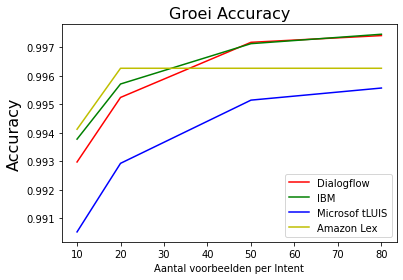

In [33]:
dialogflowgraph = [dialogflowac10, dialogflowac20, dialogflowac50, dialogflowac80]
plt.plot([10,20,50,80], dialogflowgraph, color='r')

ibmgraph = [ibmac10, ibmac20, ibmac50, ibmac80]
plt.plot([10,20,50,80], ibmgraph, color='g')

azuregraph = [azureac10, azureac20, azureac50, azureac80]
plt.plot([10,20,50,80], azuregraph, color='b')

amazongraph = [amazonac10, amazonac20, amazonac20, amazonac20]
plt.plot([10,20,50,80], amazongraph, color='y')

plt.legend(['Dialogflow','IBM','Microsof tLUIS','Amazon Lex']) 
plt.xlabel('Aantal voorbeelden per Intent')
plt.ylabel('Accuracy', fontsize=16) 
plt.title('Groei Accuracy', fontsize=16)

plt.show()